In [1]:
# import dependencies
from scipy import ndimage
import sys
import os
from time import time
from time import sleep
from PIL import Image
import numpy as np
import pandas as pd
import plotly
from plotly.graph_objs import Bar, Line
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs.scatter import Marker
from plotly.graph_objs.layout import XAxis, YAxis
import seaborn as sns
from IPython.display import Image as _Imgdis
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn import datasets as ds
import cv2  
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:

import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__


'2.2.4'

In [3]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    
 

In [4]:
# Less Data...
#asl = pd.read_csv("C:/temp/Datasets/aslalphabettrain50-test/asl_alphabet_train_50_test.csv")

# More Data...
asl = pd.read_csv("C:/temp/Datasets/aslalphabettrain50/asl_alphabet_train_50.csv")



In [5]:
import copy
aslcopy = copy.deepcopy(asl)
X=np.asarray(aslcopy.drop(asl.columns[0], axis=1), dtype=np.int64)
y=asl.drop(asl.columns[1:], axis=1)
y = np.asarray(y, dtype=np.int16)

In [6]:
print(X)
print(y)

[[ 48  50  48 ... 140 140 139]
 [ 50  49  47 ... 140 139 140]
 [ 49  50  51 ... 142 141 140]
 ...
 [ 67  82  80 ... 117 118 122]
 [ 67  81  80 ... 118 117 120]
 [ 67  83  80 ... 118 117 121]]
[[ 0]
 [ 0]
 [ 0]
 ...
 [25]
 [25]
 [25]]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

#X_train = X_train/255.0 - 0.5
#X_test = X_test/255.0 - 0.5

print(X_train.shape)

(17399, 2500)


In [8]:
img_wh = 50
NUM_CLASSES=29

X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] ))

New Shape: Rows: 17399, image size: (50,50,1)


(17399, 50, 50, 1)


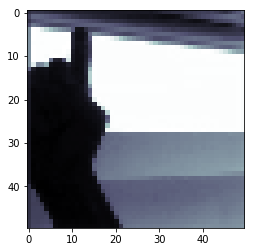

(17399, 50, 50, 1)


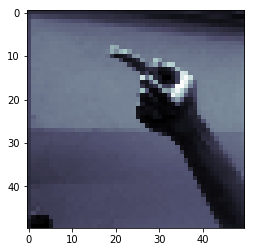

In [9]:
print(X_train.shape)
plt.subplot(1,1,1)
plt.imshow(X_train[0].squeeze(),cmap='bone')
plt.show()

print(X_train.shape)
plt.subplot(1,1,1)
plt.imshow(X_train[100].squeeze(),cmap='bone')
plt.show()

In [12]:
classes = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Space', 'Del', 'Nothing']

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

idx = 0

C:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:80: UserWarning:

Float image out of standard range; displaying image with stretched contrast.



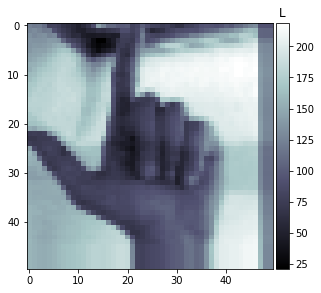

In [13]:
tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='bone')
    plt.title(classes[np.argmax(tmp[1])])
    break

In [16]:
%%time 

cnn = Sequential()



# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )


Epoch 1/5
135/135 [==============================] - 336s 2s/step - loss: 15.5087 - acc: 0.0373 - val_loss: 15.5737 - val_acc: 0.0338
Epoch 2/5
135/135 [==============================] - 331s 2s/step - loss: 15.5607 - acc: 0.0344 - val_loss: 15.5625 - val_acc: 0.0345
Epoch 3/5
135/135 [==============================] - 331s 2s/step - loss: 15.5258 - acc: 0.0364 - val_loss: 15.5548 - val_acc: 0.0345
Epoch 4/5
135/135 [==============================] - 331s 2s/step - loss: 15.5442 - acc: 0.0353 - val_loss: 15.5658 - val_acc: 0.0343
Epoch 5/5
135/135 [==============================] - 330s 2s/step - loss: 15.5617 - acc: 0.0343 - val_loss: 15.5625 - val_acc: 0.0345
Wall time: 27min 40s


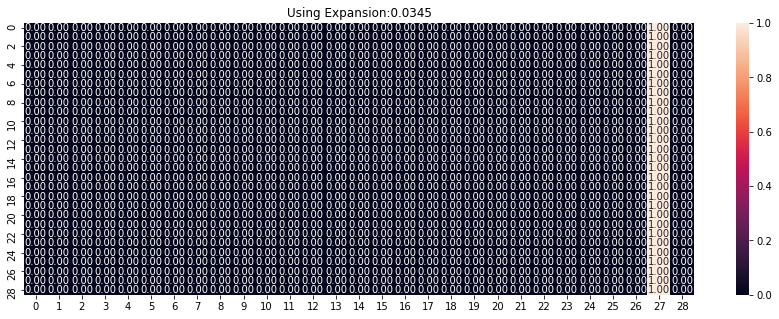

In [17]:
summarize_net(cnn, X_test, y_test, title_text='Using Expansion:')

In [18]:
# what if we just want to use the validation data??
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn = Sequential()

cnn.add(Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',
               data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=128,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
    

# add one layer on flattened output

cnn.add(Flatten())
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=50, verbose=1,
                  validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

Epoch 1/50
135/135 [==============================] - 528s 4s/step - loss: 15.6452 - acc: 0.0337 - val_loss: 15.6094 - val_acc: 0.0350
Epoch 2/50
135/135 [==============================] - 525s 4s/step - loss: 15.6260 - acc: 0.0327 - val_loss: 15.5657 - val_acc: 0.0350
Epoch 3/50
135/135 [==============================] - 525s 4s/step - loss: 15.6029 - acc: 0.0323 - val_loss: 15.5627 - val_acc: 0.0348
Epoch 4/50
135/135 [==============================] - 523s 4s/step - loss: 7.9959 - acc: 0.0340 - val_loss: 3.3702 - val_acc: 0.0338
Epoch 5/50
135/135 [==============================] - 525s 4s/step - loss: 3.3755 - acc: 0.0394 - val_loss: 3.3710 - val_acc: 0.0338
Epoch 6/50
135/135 [==============================] - 524s 4s/step - loss: 3.3709 - acc: 0.0369 - val_loss: 3.3667 - val_acc: 0.0341
Epoch 7/50
135/135 [==============================] - 524s 4s/step - loss: 3.3714 - acc: 0.0369 - val_loss: 3.3612 - val_acc: 0.0488
Epoch 8/50
135/135 [==============================] - 525s 4s/s

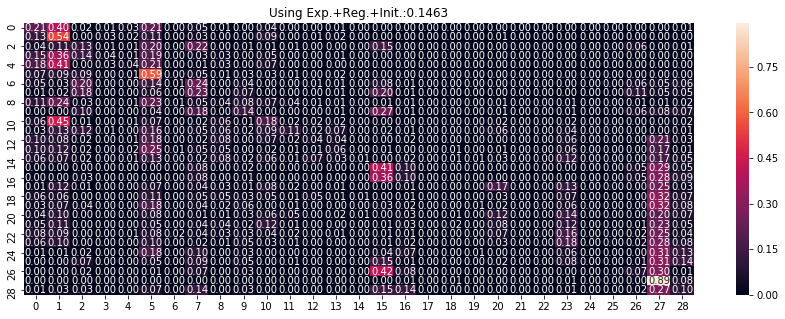

In [19]:
summarize_net(cnn, X_test, y_test, title_text='Using Exp.+Reg.+Init.:')

___
# Adding ResNet Style Blocks
Okay, so now lets try a trick from 2016---ancient in terms of deep learning years (that's a joke 🤷, ¯\\_(ツ)_/¯). 

The ResNet-Style Bypass is described in the following:
![resnet](https://cdn-images-1.medium.com/max/1600/0*0r0vS8myiqyOb79L.jpg)

In [20]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 50, 50, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 25, 25, 32)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 25, 25, 32)   9248        max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [21]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

In [ ]:
# the flow method yields batches of images indefinitely, with the given transofmrations
# resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                       steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
#                       epochs=50, verbose=1,
#                       validation_data=(X_test,y_test_ohe),
#                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#                      )

resnet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Train on 17399 samples, validate on 69600 samples
Epoch 1/50
 8576/17399 [=============>................] - ETA: 29s - loss: 15.6136 - acc: 0.0337